# Preprocessing of data

This script shows how to preprocess the data, i.e. the following steps:

1. Generation of an igraph-object that represents the genes
2. Computation of the shortest path weights
3. Generation of log-transformed node features
4. Generation of binary node labels.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from MoProEmbeddings import basegraph, utils, path_weights, features

## Step 1: Create basegraph object

Create the basegraph object from the file containing the node-features and the edges.

In [2]:
edges = np.loadtxt('./data/network.txt', dtype=str)
scores = pd.read_csv(
    './data/gene_features.txt', 
    delim_whitespace=True,
    index_col=0)

bg = basegraph.create(edges, scores)

print(f'Number of connected vertices: {len(bg.vs)}')
print(f'Number of edges: {len(bg.es)}')

Number of connected vertices: 100
Number of edges: 500


Check the attributes of the nodes that were created for each node.

In [3]:
print(f'Node attributes: {bg.vs.attributes()}')

Node attributes: ['name', 'pvalue', 'k1_neighbors', 'k1_stdWeights', 'k1_doremiWeights']


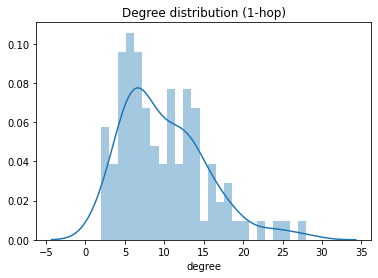

In [4]:
fig, ax = plt.subplots()
ax.set_title('Degree distribution (1-hop)')
ax.set_xlabel('degree');
sns.distplot(bg.degree(), bins=25);

## Step 2: Compute the shortest path weights.

Compute the shortest path weights of length-2 paths within the network, and store them.

__Remark__:
The computation of the shortest path weights might be slow (take a few hours) for large data sets and networks. Hence, we recommend to run this step separately and store the shortest path weights with pickle, as this only has to be done once.
It can then conveniently be loaded to run step 4.

In [5]:
k = 2
weight = 'std'
mode = 'max'

weights = path_weights.ShortestPathWeights(
    bg, max_k=k, mode=mode, weight=weight)

utils.write_pickle(weights, f'./data/{weight}_path_weights_{k}hop_{mode}.pkl')

Plot the degree distribution for the incremental 2-hop neighborhood, i.e. excluding all nodes that are already part of the 1-hop neighborhood.

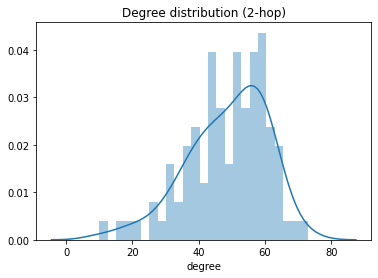

In [6]:
degree = [len(x) for x in weights.shortest_path_weights.values()]
degree_2hop = [x-y for x, y in zip(degree, bg.degree())]

fig, ax = plt.subplots()
ax.set_title('Degree distribution (2-hop)')
ax.set_xlabel('degree');
sns.distplot(degree_2hop, bins=25);

## Step 3: Compute the node-features.

Log-transformation of the node features.

In [7]:
bg = features.log_transform(bg, 'pvalue')

## Step 4: add (binary) node-labels.

For every node, add a class label. E.g. for cancer genes, this could be the cancer status of each gene according to a database such as the Cancer Gene Census (CGC) from the Cosmic database (https://cancer.sanger.ac.uk/census).

For the purpose of this Tutorial, we use a randomly generated, binary label.

In [8]:
labels = np.random.uniform(0, 1, len(bg.vs))
labels = [1 if x > 0.75 else 0 for x in labels]
bg.vs['class_label'] = labels

Print the list of the node attributes in the igraph-object, and pickle it.

In [9]:
utils.write_pickle(bg, './data/basegraph.pkl')